In [76]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from itertools import combinations

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('matchups_womens_first_weekend.csv')
print(df.shape)
df.head()

(336, 49)


,game_id,year,round,region,high_team_id,low_team_id,win,ppg,opp_ppg,net_ppg,...,3prd,%pts_ftd,%pts_2pd,%pts_3pd,astd%,tovd%,opp_ast_tov,opp_stl%,opp_blk%,opp_pf%
0,20171101,2017,First Round,East,2017 Connecticut,2017 Albany,1,23.1000,-10.8000,30.6000,...,0.0810,0.0500,0.0400,0.0900,-0.1170,-0.0110,-0.1800,-0.0480,-0.0510,-0.0290
1,20171108,2017,First Round,East,2017 Syracuse,2017 Iowa St.,1,9.9000,-6.4000,6.3000,...,-0.0440,0.0160,0.0430,0.0270,0.0800,0.1030,-0.4700,-0.0020,0.0000,0.0100
2,20171106,2017,First Round,East,2017 Texas A&M,2017 Penn,1,16.3000,2.8000,-2.3000,...,-0.0610,0.0070,0.0940,0.0880,-0.0590,0.0220,-0.1900,-0.0120,-0.0700,0.0500
3,20171104,2017,First Round,East,2017 UCLA,2017 Boise St.,1,10.4000,-4.1000,6.2000,...,-0.0370,0.0430,0.0120,0.0320,-0.0240,0.0350,-0.2900,-0.0220,-0.0270,-0.0070
4,20171103,2017,First Round,East,2017 West Virginia,2017 Elon,1,14.6000,-7.4000,0.9000,...,0.0030,0.0120,0.0230,0.0120,-0.0510,0.0170,-0.2400,0.0000,-0.0320,-0.0140


In [77]:
df['win'].value_counts(normalize=True)

1   0.7202
0   0.2798
Name: win, dtype: float64

In [78]:
df.columns

Index(['game_id', 'year', 'round', 'region', 'high_team_id', 'low_team_id',
       'win', 'ppg', 'opp_ppg', 'net_ppg', 'off_rtg', 'def_rtg', 'net_rtg',
       'pace', 'hhs_net_rtg', 'hhs_off_rtg', 'hhs_def_rtg', 'rpi', 'ppp',
       'ppsa', 'efg%', 'ftr', '3pr', '%pts_ft', '%pts_2p', '%pts_3p', 'orb%',
       'drb%', 'trb%', 'ast%', 'tov%', 'ast_tov', 'stl%', 'blk%', 'pf%',
       'pppd', 'opp_ppsa', 'efgd%', 'ftrd', '3prd', '%pts_ftd', '%pts_2pd',
       '%pts_3pd', 'astd%', 'tovd%', 'opp_ast_tov', 'opp_stl%', 'opp_blk%',
       'opp_pf%'],
      dtype='object')

In [79]:
eda_df = df[[
    'win', 'ppg', 'opp_ppg', 'net_ppg', 'off_rtg', 'def_rtg', 'net_rtg',
       'pace', 'hhs_net_rtg', 'hhs_off_rtg', 'hhs_def_rtg', 'rpi', 'ppp',
       'ppsa', 'efg%', 'ftr', '3pr', '%pts_ft', '%pts_2p', '%pts_3p', 'orb%',
       'drb%', 'trb%', 'ast%', 'tov%', 'ast_tov', 'stl%', 'blk%', 'pf%',
       'pppd', 'opp_ppsa', 'efgd%', 'ftrd', '3prd', '%pts_ftd', '%pts_2pd',
       '%pts_3pd', 'astd%', 'tovd%', 'opp_ast_tov', 'opp_stl%', 'opp_blk%',
       'opp_pf%']]

In [80]:
# Split dataset into a train and test set
X = eda_df.drop('win', axis=1)
Y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(train_df.shape)
print(test_df.shape)

(235, 43)
(101, 43)


### I. Numerical Tests

In [81]:
corr_matrix = train_df.corr()
correlation_with_target = round(abs(corr_matrix['win'])*100,2)
correlation_with_target = correlation_with_target[correlation_with_target >= 10]
print(correlation_with_target)

ppg            16.3800
opp_ppg        22.5700
net_ppg        40.4500
off_rtg        12.7300
def_rtg        21.7900
net_rtg        39.7000
pace           12.1600
hhs_net_rtg    56.1000
hhs_def_rtg    26.3300
rpi            59.7500
ppp            11.0200
ftr            22.0000
3pr            20.0000
%pts_3p        15.9100
trb%           34.1500
ast%           12.3300
tov%           17.1200
ast_tov        14.8900
stl%           14.3200
blk%           16.4900
pppd           20.1500
opp_ppsa       12.0700
efgd%          13.4100
ftrd           11.8000
tovd%          15.2700
opp_ast_tov    17.9200
opp_pf%        10.1800
win           100.0000
Name: win, dtype: float64


In [82]:
X = train_df.drop('win', axis=1)
y = train_df['win']

# ANOVA
f_values, p_values = f_classif(X, y)
# Mutual Information
mi = mutual_info_regression(X, y)

column_names = np.array(X.columns)
stats_df = pd.DataFrame({
    'feature': column_names,
    'f_values': f_values,
    'p_values': p_values,
    'mutual_info': mi
})
stats_df

,feature,f_values,p_values,mutual_info
0,ppg,6.4279,0.0119,0.0296
1,opp_ppg,12.5101,0.0005,0.0318
2,net_ppg,45.5723,0.0000,0.1016
3,off_rtg,3.8382,0.0513,0.0268
4,def_rtg,11.6159,0.0008,0.0212
5,net_rtg,43.6053,0.0000,0.1119
6,pace,3.4985,0.0627,0.0147
7,hhs_net_rtg,107.0051,0.0000,0.2420
8,hhs_off_rtg,0.6552,0.4191,0.0000
9,hhs_def_rtg,17.3517,0.0000,0.0361


In [83]:
stats_df[stats_df['mutual_info'] > .05]

,feature,f_values,p_values,mutual_info
2,net_ppg,45.5723,0.0000,0.1016
5,net_rtg,43.6053,0.0000,0.1119
7,hhs_net_rtg,107.0051,0.0000,0.2420
10,rpi,129.3543,0.0000,0.2434
15,3pr,9.7097,0.0021,0.0612
21,trb%,30.7614,0.0000,0.0868
25,stl%,4.8791,0.0282,0.0930
29,opp_ppsa,3.4473,0.0646,0.0578
31,ftrd,3.2885,0.0711,0.0995


In [84]:
stats_df[stats_df['p_values'] < .05]

,feature,f_values,p_values,mutual_info
0,ppg,6.4279,0.0119,0.0296
1,opp_ppg,12.5101,0.0005,0.0318
2,net_ppg,45.5723,0.0000,0.1016
4,def_rtg,11.6159,0.0008,0.0212
5,net_rtg,43.6053,0.0000,0.1119
7,hhs_net_rtg,107.0051,0.0000,0.2420
9,hhs_def_rtg,17.3517,0.0000,0.0361
10,rpi,129.3543,0.0000,0.2434
14,ftr,11.8503,0.0007,0.0248
15,3pr,9.7097,0.0021,0.0612


In [85]:
stats_df[stats_df['f_values'] > 5]

,feature,f_values,p_values,mutual_info
0,ppg,6.4279,0.0119,0.0296
1,opp_ppg,12.5101,0.0005,0.0318
2,net_ppg,45.5723,0.0000,0.1016
4,def_rtg,11.6159,0.0008,0.0212
5,net_rtg,43.6053,0.0000,0.1119
7,hhs_net_rtg,107.0051,0.0000,0.2420
9,hhs_def_rtg,17.3517,0.0000,0.0361
10,rpi,129.3543,0.0000,0.2434
14,ftr,11.8503,0.0007,0.0248
15,3pr,9.7097,0.0021,0.0612


### II. Wrapper Methods

In [86]:
X_train = train_df.drop('win', axis=1)
y_train = train_df['win']

X_test = test_df.drop('win', axis=1)
y_test = test_df['win']

float64_columns = X_train.select_dtypes(include=['float64']).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[float64_columns] = scaler.fit_transform(X_train[float64_columns])

X_test_scaled = X_test.copy()
X_test_scaled[float64_columns] = scaler.transform(X_test[float64_columns])

In [87]:
X_train_scaled.head()

,ppg,opp_ppg,net_ppg,off_rtg,def_rtg,net_rtg,pace,hhs_net_rtg,hhs_off_rtg,hhs_def_rtg,...,3prd,%pts_ftd,%pts_2pd,%pts_3pd,astd%,tovd%,opp_ast_tov,opp_stl%,opp_blk%,opp_pf%
93,0.1870,0.3347,-0.0555,-0.6112,-0.3031,-0.1739,0.9129,-0.6860,0.2698,-0.8387,...,0.8873,0.5103,-1.3205,-0.4406,1.0074,0.3782,0.4039,0.4675,0.3570,-0.8220
30,-1.4039,-1.2284,-1.4794,-1.3183,-0.8033,-1.3048,-0.7574,-0.5094,-1.0547,-0.7006,...,-0.0554,-1.0929,-1.1988,-1.1039,0.0890,-0.2972,-0.3061,-0.4829,0.9010,1.2543
22,-0.6615,-0.9238,-2.0838,0.2007,-0.0793,-2.0088,-1.3282,-1.7983,1.0287,-0.8387,...,1.3653,-0.7629,1.7456,1.3435,0.8360,-0.7835,0.7775,-0.9149,-0.2549,1.5677
286,0.6908,0.6791,-0.6291,0.8162,0.7763,-0.7730,0.0249,-0.7919,0.4930,0.3906,...,1.0334,-0.7157,0.4559,0.0855,0.3707,-0.1081,0.4412,-0.0941,-0.9008,-1.3313
296,1.3139,-0.2349,2.0651,1.2484,-0.6848,1.9532,0.6592,1.2797,2.0556,-1.3083,...,0.6483,-0.7629,-0.1038,0.0626,0.5544,0.0540,-0.0072,0.0787,-1.4788,-1.2138


In [88]:
X_test_scaled.head()

,ppg,opp_ppg,net_ppg,off_rtg,def_rtg,net_rtg,pace,hhs_net_rtg,hhs_off_rtg,hhs_def_rtg,...,3prd,%pts_ftd,%pts_2pd,%pts_3pd,astd%,tovd%,opp_ast_tov,opp_stl%,opp_blk%,opp_pf%
72,0.1605,-0.0760,1.1944,0.1483,-0.2109,1.2492,0.0038,1.3739,0.2698,-0.3553,...,-0.4537,0.0859,-0.7608,-0.1204,-0.6212,-0.2161,-0.0445,1.2451,-0.3909,-0.6653
110,2.1359,0.7188,0.3748,1.5626,-0.6058,0.1407,1.8221,0.3734,1.4603,-0.7144,...,0.2102,0.6989,-0.5904,-1.3098,0.6523,-0.7294,0.7775,-0.0077,-1.2408,0.3924
298,-0.0516,0.3611,-0.6599,-0.2052,0.1313,-0.6831,0.4478,-1.0097,0.2102,-0.1895,...,-0.0155,-0.6686,-1.2475,-0.9209,-0.5722,-0.4593,-0.1566,1.5907,0.4590,1.2543
108,1.8310,1.6725,2.0651,1.7198,1.8951,1.9007,0.8072,2.5569,1.0139,1.3022,...,0.7015,3.0565,-0.2011,-0.5092,1.1299,-0.9726,1.8611,0.1651,0.5610,-0.7045
277,-0.5687,-0.7251,-0.3320,-1.1219,-1.5931,-0.3985,0.4055,-0.5035,-1.0101,-0.9907,...,-1.1176,2.2549,0.3343,1.9610,0.7013,0.0270,-0.0819,-0.3965,0.4250,-0.4303


In [89]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(X_train_scaled, y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [90]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 42
selected features: 22
features with coefficients shrank to zero: 20


In [91]:
selected_feat

Index(['def_rtg', 'pace', 'hhs_net_rtg', 'hhs_off_rtg', 'rpi', 'ppp', 'ppsa',
       'ftr', '3pr', '%pts_ft', '%pts_3p', 'orb%', 'trb%', 'ast%', 'ast_tov',
       'stl%', 'pf%', '%pts_ftd', '%pts_2pd', '%pts_3pd', 'opp_ast_tov',
       'opp_blk%'],
      dtype='object')

In [92]:
# Transform datasets based on selected features
X_train_selected = sel_.transform(X_train_scaled)
X_test_selected = sel_.transform(X_test_scaled)

# Train a Lasso regression model
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_selected, y_train)

# Make predictions
y_train_pred = lasso.predict(X_train_selected)
y_test_pred = lasso.predict(X_test_selected)

# Convert predictions to binary using a threshold
threshold = 0.5
y_train_pred_binary = (y_train_pred >= threshold).astype(int)
y_test_pred_binary = (y_test_pred >= threshold).astype(int)

# Evaluate F1 scores
f1_train = f1_score(y_train, y_train_pred_binary)
f1_test = f1_score(y_test, y_test_pred_binary)

print(f"Lasso Regression F1 Score (Train): {f1_train:.2f}")
print(f"Lasso Regression F1 Score (Test): {f1_test:.2f}")

Lasso Regression F1 Score (Train): 0.87
Lasso Regression F1 Score (Test): 0.90


In [93]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [94]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [95]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['hhs_net_rtg', 'rpi', 'ppp', 'ftr', '%pts_3p', 'drb%', 'stl%',
       'efgd%', 'ftrd', '%pts_2pd'], dtype=object)

In [96]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9592282172166929
Test set
Random Forests roc-auc: 0.9147368421052632


In [97]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9655142308363891
Test set
Random Forests roc-auc: 0.8921052631578947


In [98]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.49842105263157893,
 0.48236842105263156,
 0.6328947368421053,
 0.52,
 0.6286842105263158,
 0.5842105263157895,
 0.5847368421052632,
 0.7042105263157896,
 0.4944736842105263,
 0.5268421052631579,
 0.8271052631578948,
 0.4634210526315789,
 0.6139473684210526,
 0.45,
 0.5755263157894737,
 0.596578947368421,
 0.5544736842105262,
 0.41657894736842105,
 0.5063157894736842,
 0.5207894736842106,
 0.4718421052631579,
 0.5307894736842105,
 0.588421052631579,
 0.6160526315789474,
 0.6492105263157895,
 0.45894736842105266,
 0.5652631578947368,
 0.6721052631578948,
 0.5336842105263158,
 0.5036842105263157,
 0.5571052631578948,
 0.48578947368421055,
 0.5042105263157894,
 0.43236842105263157,
 0.46789473684210525,
 0.4431578947368421,
 0.45947368421052637,
 0.5339473684210526,
 0.5639473684210525,
 0.6097368421052631,
 0.5607894736842105,
 0.515]

Text(0, 0.5, 'roc-auc')

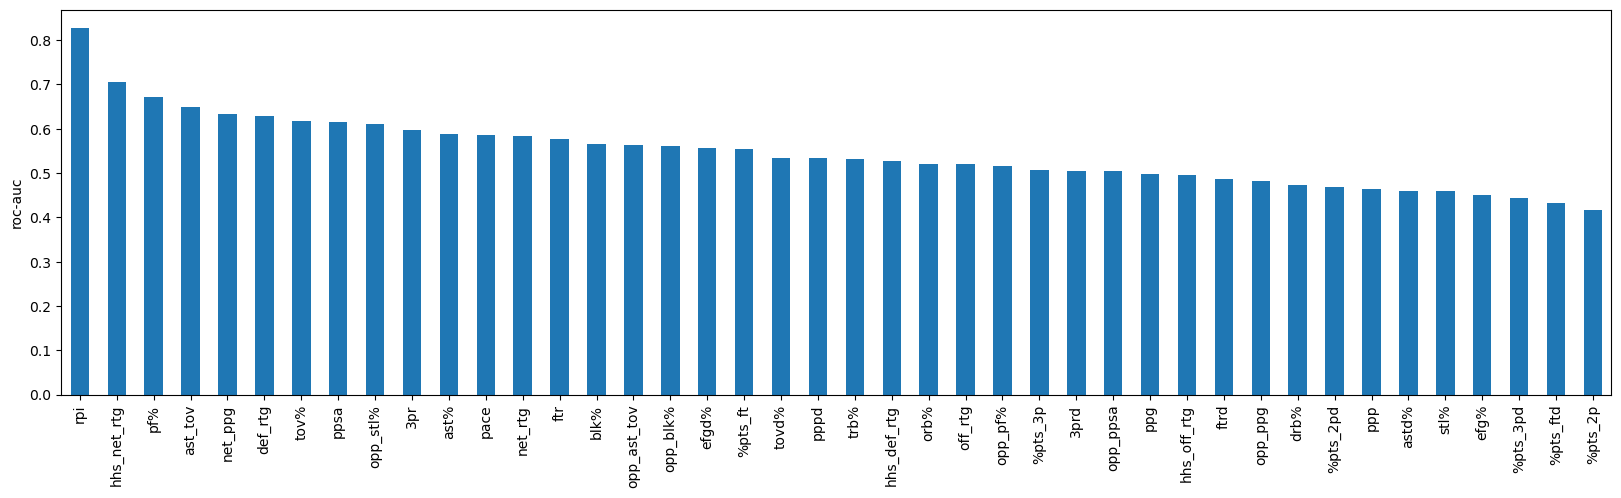

In [99]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [100]:
len(roc_values[roc_values > 0.5])

29

In [101]:
len(roc_values[roc_values > 0.6])

9

In [102]:
roc_values[roc_values > 0.6]

net_ppg       0.6329
def_rtg       0.6287
hhs_net_rtg   0.7042
rpi           0.8271
ppsa          0.6139
tov%          0.6161
ast_tov       0.6492
pf%           0.6721
opp_stl%      0.6097
dtype: float64

### IV. Exhaustive Feature Selection

In [103]:
X_train_scaled2 = X_train_scaled[[
 'hhs_net_rtg',
 'rpi',
 'net_ppg',
 'net_rtg',
 '3pr',
 'trb%',
 'stl%',
 'ppp',
 '%pts_3p',
 'def_rtg',
 'ftr',
 'tov%',
 'efgd%',
 'ftrd',
]]

X_test_scaled2 = X_test_scaled[[
 'hhs_net_rtg',
 'rpi',
 'net_ppg',
 'net_rtg',
 '3pr',
 'trb%',
 'stl%',
 'ppp',
 '%pts_3p',
 'def_rtg',
 'ftr',
 'tov%',
 'efgd%',
 'ftrd',
]]

In [104]:
# Initialize variables to track the best model
log_reg = LogisticRegression(solver='liblinear')
best_f1 = 0
best_features = []
best_train_f1 = 0

# Iterate over all possible subsets of features
for k in range(1, len(X_train_scaled2.columns) + 1):
    for subset in combinations(X_train_scaled2.columns, k):
        X_train_subset = X_train_scaled2[list(subset)]
        X_test_subset = X_test_scaled2[list(subset)]
        
        # Train the model with the subset of features
        log_reg.fit(X_train_subset, y_train)
        
        # Make predictions on the test set
        y_test_pred = log_reg.predict(X_test_subset)
        test_f1 = f1_score(y_test, y_test_pred)
        
        # Make predictions on the training set
        y_train_pred = log_reg.predict(X_train_subset)
        train_f1 = f1_score(y_train, y_train_pred)
        
        # Track the best subset based on test F1 score
        if test_f1 > best_f1:
            best_f1 = test_f1
            best_features = subset
            best_train_f1 = train_f1

# Output the best feature subset and the F1 scores
print(f"Best Feature Subset: {best_features}")
print(f"Best Test F1 Score: {best_f1:.4f}")
print(f"Training F1 Score of Best Model: {best_train_f1:.4f}")

Best Feature Subset: ('hhs_net_rtg', 'net_rtg', '%pts_3p')
Best Test F1 Score: 0.9299
Training F1 Score of Best Model: 0.9006


### V. XG Boost

In [105]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up hyperparameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400, 500, 1000],
    'subsample': [0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
    'gamma': [0.2, 0.3, 0.4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train_scaled2, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best Hyperparameters: {'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.4}


In [106]:
# Retrain the model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    **best_params
)

best_xgb_model.fit(X_train_scaled2, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [107]:
# Predict probabilities
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled2)[:, 1]

# Calculate Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss on test set: {logloss}")

Log Loss on test set: 0.3701376074208501


In [108]:
# Predictions
y_train_pred = best_xgb_model.predict(X_train_scaled2)
y_test_pred = best_xgb_model.predict(X_test_scaled2)

# Calculate accuracy scores
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"F1 Score on Training Data: {f1_train:.2f}")
print(f"F1 Score on Test Data: {f1_test:.2f}")

F1 Score on Training Data: 0.98
F1 Score on Test Data: 0.89


<Figure size 1000x600 with 0 Axes>

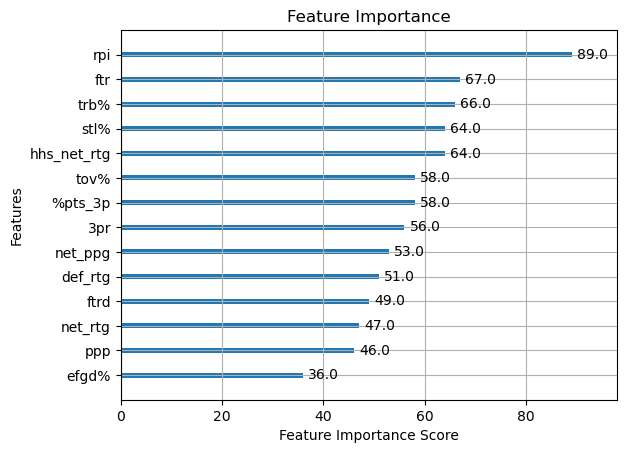

Feature importance (sorted):


NameError: name 'feature_names' is not defined

In [109]:
from xgboost import plot_importance

# Extract feature importance
feature_importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# Visualize feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model, importance_type='weight', show_values=True, xlabel='Feature Importance Score')
plt.title('Feature Importance')
plt.show()

# Print sorted feature importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
print("Feature importance (sorted):")
for feature, importance in sorted_importance:
    print(f"{feature_names[int(feature[1:])]}: {importance}")

In [110]:
X_train_scaled3 = X_train_scaled[[
 'hhs_net_rtg',
 'rpi',
 'stl%',
 'ppp',
 '%pts_3p',
 'ftr',
 'efgd%',
 'ftrd',
 '%pts_2pd',
 'drb%'
]]

X_test_scaled3 = X_test_scaled[[
 'hhs_net_rtg',
 'rpi',
 'stl%',
 'ppp',
 '%pts_3p',
 'ftr',
 'efgd%',
 'ftrd',
 '%pts_2pd',
 'drb%'
]]

In [111]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up hyperparameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400, 500, 1000],
    'subsample': [0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
    'gamma': [0.2, 0.3, 0.4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train_scaled3, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best Hyperparameters: {'colsample_bytree': 0.4, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.4}


In [112]:
# Retrain the model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    **best_params
)

best_xgb_model.fit(X_train_scaled3, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [113]:
# Predict probabilities
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled3)[:, 1]

# Calculate Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss on test set: {logloss}")

Log Loss on test set: 0.33036293310717546


In [114]:
# Predictions
y_train_pred = best_xgb_model.predict(X_train_scaled3)
y_test_pred = best_xgb_model.predict(X_test_scaled3)

# Calculate accuracy scores
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"F1 Score on Training Data: {f1_train:.2f}")
print(f"F1 Score on Test Data: {f1_test:.2f}")

F1 Score on Training Data: 0.97
F1 Score on Test Data: 0.90


<Figure size 1000x600 with 0 Axes>

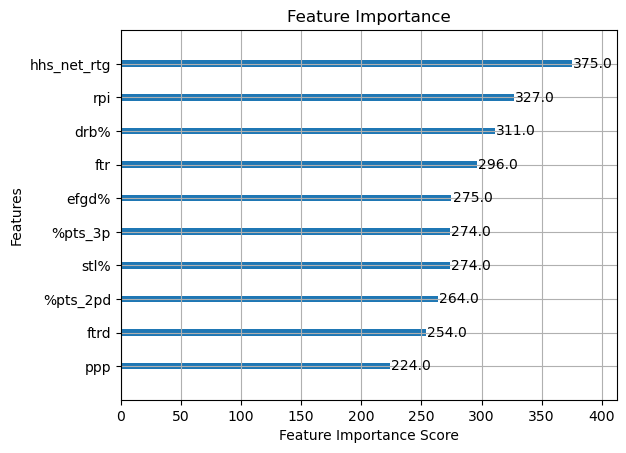

Feature importance (sorted):


NameError: name 'feature_names' is not defined

In [115]:
from xgboost import plot_importance

# Extract feature importance
feature_importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# Visualize feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model, importance_type='weight', show_values=True, xlabel='Feature Importance Score')
plt.title('Feature Importance')
plt.show()

# Print sorted feature importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
print("Feature importance (sorted):")
for feature, importance in sorted_importance:
    print(f"{feature_names[int(feature[1:])]}: {importance}")